# ASPM
[Primary microcephaly-5 (MCPH5)](https://omim.org/entry/608716) is caused by homozygous or compound heterozygous mutation in the ASPM gene.
The ASPM gene encodes a protein that plays a critical role in neurogenesis, particularly in the regulation of mitotic spindle function during cell division in neural progenitor cells ([PMID: 16798874](https://pubmed.ncbi.nlm.nih.gov/16798874/)). 

Autosomal recessive primary microcephaly-5 (MCPH5) is characterized by primnary microcephaly, intellectualdisability, and speech delay.

We performed the following PubMed query on 2024-09-24

  
```bash
  (Microcephaly 5 OR LDS3 OR "MCPH5") AND 
  (# ASPM OR "# ASPM variants" OR "# ASPM mutations") AND 
  ("genotype phenotype correlation"    OR " phenotype genotype correlation")
```

The query retrieved one citation, [Paracha et al., 2024, PMID: 39281811](https://pubmed.ncbi.nlm.nih.gov/39281811/), which reported  30 pathogenic variants including one in ASPM. We did not identify a published article with an investigation of genotype phenotype correlations in ASPM. 

In [1]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopacket_folder
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable
import hpotk
import gpsea

from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.1.dev0


### ASPM
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ASPM.

In [3]:
gene_symbol = 'ASPM'
mane_tx_id = 'NM_018136.5'
mane_protein_id = 'NP_060606.3' # abnormal spindle-like microcephaly-associated protein isoform 1

### Phenopackets
We loaded a cohort of 22 phenopackets representing published descriptions of individuals with pathogenic variants in ASPM diagnosed with MCPH5.

In [4]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.19'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')

Loaded 22 phenopackets


In [5]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Individuals Processed: 100%|██████████| 22/22 [00:00<00:00, 1377.58individuals/s]
Loaded 22 individuals
Validated under none policy
No errors or warnings were found


# Explorative analysis

Given the lack of information about potential correlations in the literature, we sought common variants or apparent clustering of variants using the following GPSEA code.

In [6]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
report = cv.process(cohort, transcript_id=mane_tx_id)
display(HTML(report))

HPO Term,ID,Seen in n individuals
Microcephaly,HP:0000252,22
Intellectual disability,HP:0001249,18
Short stature,HP:0004322,16
Decreased body weight,HP:0004325,14
Hyperactivity,HP:0000752,7
Aggressive behavior,HP:0000718,3
Self-injurious behavior,HP:0100716,2
Motor delay,HP:0001270,1
Opisthotonus,HP:0002179,1
Simplified gyral pattern,HP:0009879,1


In [7]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_14472/1613228306.py:4: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


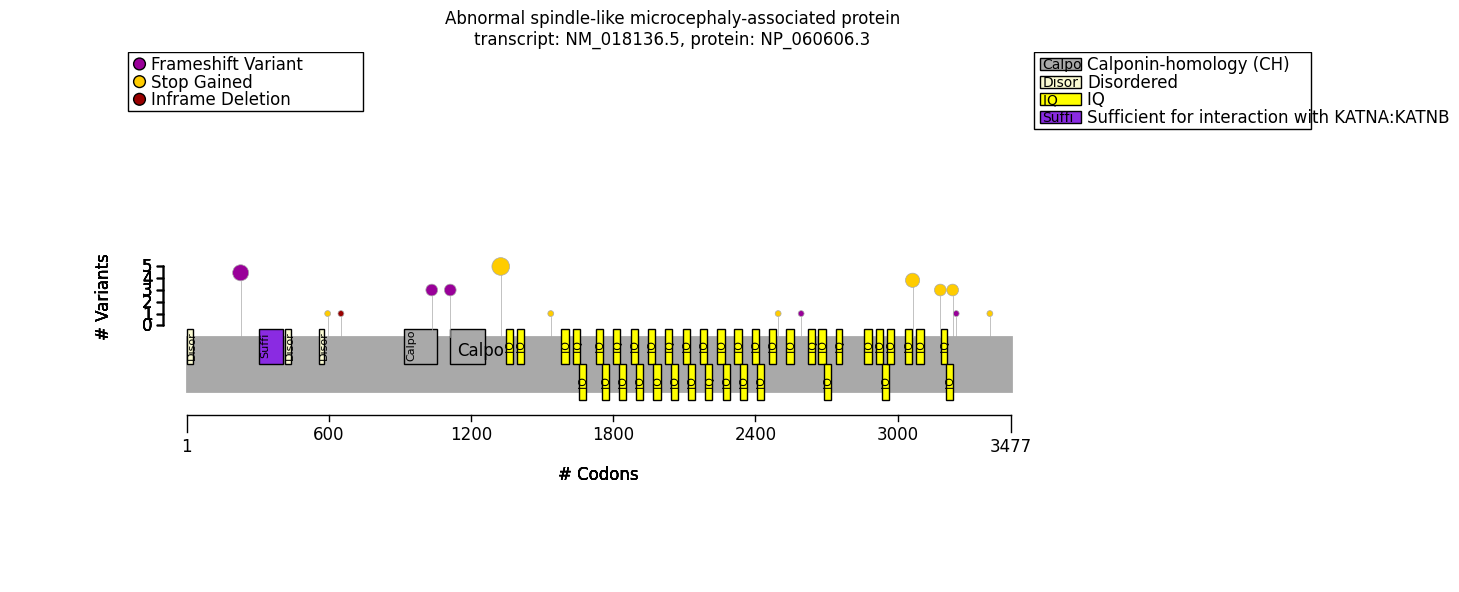

In [8]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

## Strategy
We see that all published variants belong to categories such as frameshift or stop gained (nonsense) that are often considered to be loss of function variants, so there is no obvious hypothesis to make regarding correlations between different variant classes. We see that roughly half of the published variants are located N-terminal to residue 1200, so we will perform the corresponding region test.

In [9]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, ModeOfInheritancePredicate

n_term = VariantPredicates.region(region=Region(0, 1200), tx_id=mane_tx_id)
gt_predicate = ModeOfInheritancePredicate.autosomal_recessive(n_term)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_14472/2891423028.py:7: DeprecationWarning: Use `gpsea.analysis.predicate.genotype.autosomal_recessive` instead
  gt_predicate = ModeOfInheritancePredicate.autosomal_recessive(n_term)


In [10]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [11]:
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

In [12]:
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [14]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
display(HTML(report))

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,3
HMF04,Skipping term because all genotypes have same HPO observed proportions,19
HMF06,Skipping term with less than 6 observations (not powered for 2x3),5
HMF08,Skipping general term,16


In [15]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group         HOM_REF           HET          \
                                     Count Percent Count Percent   
Short stature [HP:0004322]           11/14     79%   1/2     50%   
Decreased body weight [HP:0004325]    8/14     57%   2/2    100%   
Hyperactivity [HP:0000752]            4/13     31%   1/2     50%   

What is the genotype group         BIALLELIC_ALT                             \
                                           Count Percent Corrected p values   
Short stature [HP:0004322]                   4/6     67%                1.0   
Decreased body weight [HP:0004325]           4/6     67%                1.0   
Hyperactivity [HP:0000752]                   2/5     40%                1.0   

What is the genotype group                    
                                    p values  
Short stature [HP:0004322]          0.476780  
Decreased body weight [HP:0004325]  0.812178  
Hyperactivity [HP:0000752]          1.000000

# Summary

No evidence was found for a genotype phenotype correlation in the ASPM gene.